# Asset Purchase Bid Optimizer

## 0. Setup

### Packages and constants

In [1]:
# Don't have yfinance? Uncomment the next line and run this cell
#!pip3 install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, gamma

TICKERS = ["IBM"]
PERIOD = "10y"
# Daily interest rate
annual_r = 0.02
R = np.power(1 + annual_r, 1 / 250) - 1
print(R)

7.921364641982898e-05


### Data

In [3]:
data = yf.download(tickers=TICKERS, period=PERIOD, interval="1d")
print(data.shape)
data.head()

[*********************100%***********************]  1 of 1 completed
(2517, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-03-11,200.803055,200.956024,199.847031,200.841293,134.830643,3189986
2013-03-12,200.191208,201.462708,199.894836,201.290634,135.132294,3756814
2013-03-13,200.956024,203.021027,200.544937,202.734222,136.101440,3510271
2013-03-14,202.820267,206.367111,202.820267,206.309753,138.501801,5758753
2013-03-15,205.908218,206.405350,204.024857,205.468445,137.936981,8295094


## 1. Model specification

We have steps $k\in\{0,1,...,N\}$; $r$ denotes the daily interest rate.  

### Random variation
$\omega_k$ is the log of the ratio between the daily low and the daily opening price. Mathematically:
$$\omega_k\equiv\log\Big(\frac{\text{low}}{\text{open}}\Big)$$
We will assume that $\omega_k$'s negative, noted $\tilde\omega_k$, follows an exponential distribution of parameter $\lambda$, i.e.:
$$-\omega_k=\tilde\omega_k\sim \exp(\lambda)
\Longleftrightarrow
\mathbb{E}\big[\tilde\omega_k\big]=\frac{1}{\lambda}
$$

0.007907245519928554 0.007907245519928557


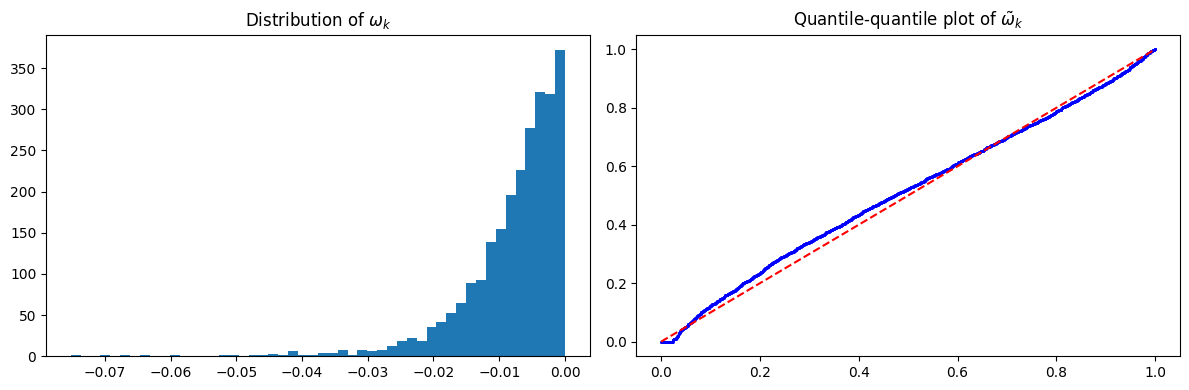

In [4]:
intraday_low = np.log(data.Low / data.Open)
lam = -1 / intraday_low.mean()
intraday_low_generator = expon(*expon.fit(-intraday_low))
print(1 / lam, intraday_low_generator.expect())

axes = plt.subplots(ncols=2, figsize=(12, 4))[1]
axes[0].hist(intraday_low, bins=50)
axes[0].set_title("Distribution of $\\omega_k$")

x = np.sort(-intraday_low)
u = np.linspace(0,1,len(x))
axes[1].plot(u, u, color="r", linestyle="dashed")
axes[1].scatter(u, intraday_low_generator.cdf(x), s=1, color="b")
axes[1].set_title("Quantile-quantile plot of $\\tilde\omega_k$")
plt.tight_layout()
plt.show()

Not a bad approximation!

### Decision variable
$u_k$ is our daily bid, expressed as the log of the ratio between our bid and the opening price. Mathematically:
$$u_k\equiv\log\Big(\frac{\text{bid}}{\text{open}}\Big)\quad\forall k<N$$

If $k=N$, we set $u_k$ to an arbitrary high but finite value:
- since stocks tend to increase in value over time (on average..!), we expect to pay more for the asset if we roll over our bidding further than the initial deadline we set ourselves  
- *however*, it's not the end of the world if we don't make the purchase, so an infinite cost would not make practical sense, especially considering that the distribution used to model $\tilde\omega_k$ takes values on $(0,+\infty)$.  

Let $\xi^{(m)}\equiv\log\Big(\frac{\text{close}_m}{\text{open}_0}\Big)$. Then, $u_N^{(k)}=f(\xi^{(N-k)})$, with $f()$ a tfunction of our choosing. NB: although we can use a value of $u_N^{(k)}$ recursively to compute step $k$'s optimal policy, the distribution of $\xi^{(N-k)}$ will shift as we get closer to our deadline, hence the dual indexing.  

In the following, we will compare policies for two functions:  
1. $f(X)=\mathbb{E}\big[X\big]$
2. $f(X)=q_{0.95}(X)$, i.e. the $95^{th}$ quantile of $X$

In [5]:
# This function will help us compute the xi values
def look_forward_ratios(df, N):
    return np.log(df.Close.shift(-N) / df.Open).dropna()

# Example with N = 10
xi_N10 = look_forward_ratios(data, 10)
u_N10 = xi_N10.mean()
print(f"{round(u_N10, 6)} => Larger than expected daily low? {u_N10 > -lam}")

q95 = lambda x: np.quantile(x, .95) # We'll reuse this...
print(f"Alternatively, using the 95th quantile: {round(q95(xi_N10), 6)}")

-0.001716 => Larger than expected daily low? True
Alternatively, using the 95th quantile: 0.068462


### State variable
Our state variable is simply an indicator telling us whether we are still attempting to purchase the asset:
$$x_k\equiv\Bigg\{
\begin{array}{cc}
    1 & \text{if}\ \omega_j>u_j\ \forall j<k \\
    0 & \text{otherwise}\\
\end{array}
$$  
NB: if $x_k=0$, no more decisions are being taken.

### Cost function (step-wise)
Only the step where the purchase is made has a non-zero cost function, equal to the discounted daily bid. Since our bids are expressed as logs, the discounting follows an arithmetic rather than geometric sequence.
$$g_k(x_k, u_k,\omega_k)\equiv\Bigg\{
\begin{array}{cc}
    u_k - k\log(1+r) & \text{if}\ \omega_k\le u_k \text{ and } x_k=1\\
    0 & \text{otherwise}\\
\end{array}
$$  

### Optimal expected cost

As mentioned earlier, the terminal value derived from the distribution of $\xi^{(N-k)}$ will change as $N-k\rightarrow 0$. Therefore, we need to use a two-dimensional time scale, evaluating at step $k$ the forward undiscounted value of each step $j>k$:

$$J_j^{(k)}\equiv\Bigg\{
\begin{array}{cc}
    0               &   \text{if}\ x_j=0 \\
    u_N^{(k)}       &   \text{if}\ x_j=1 \text{ and } j=N \\
    u_j             &   \text{if}\ x_j=1 \text{ and } j<N  \text{ and }u_j\ge\omega_k   \\
    J_{j+1}^{(k)}-log(1+r) & \text{otherwise}
\end{array}
$$  

### Optimal policy

The way our problem is formulated lets us derive analytically an optimal policy. First, let us define a few abbreviations to alleviate the notation:  
- $A_k\equiv\big\{\{x_k=1\}\cap\{k<N\}\big\}$
- $p_u\equiv\mathbb{P}(\omega_k\le u_k|x_k=1) = \mathbb{P}(\tilde\omega_k > -u_k|x_k=1)$
- $\gamma_k\equiv\mathbb{E}\big[J_{k+1}|\{A_k\}\cap\{\omega_k >u_k\}\big] - \log(1+r)$  

NB: we dropped the dual indexing introduced in the previous subheader, because at this point we simply want to compute the optimal policy for a fixed step in the process.

For $k\in\{0,1,...,N-1\}$, we have:
$$J_k|A_k = \Bigg\{
\begin{array}{cc}
    u_k         & \text{if}\ \omega_j\le u_j \\
    \gamma_k    & \text{if}\ \omega_j > u_j
\end{array}
$$ 
Therefore:
$$\mathbb{E}\big[J_k|A_k\big] = p_u u_k + (1-p_u)\gamma_k$$
Recall that if $X\sim\exp(\lambda)$, its probability density function $f_X$ and cumulative distribution function $F_X$ are:
$$
f_X(x)=\lambda e^{-\lambda x}
\quad\text{and}\quad
F_X(x)=1-e^{-\lambda x} \\
\begin{aligned}
\Longrightarrow\quad\quad
 p_u &= F_{\tilde\omega_k}(-u_k)=e^{\lambda u_k} \\
\text{and}\quad
 \frac{\partial}{\partial u_k}p_u
&=f_{\tilde\omega_k}(-u_k)=\lambda e^{\lambda u_k}
\end{aligned}
$$
This makes our expectation quite easily derivable:
$$
\begin{aligned}
\frac{\partial}{\partial u_k}\big(p_u u_k + (1 - p_u) \gamma_k \big)
&= \frac{\partial}{\partial u_k}(p_u u_k) - \gamma_k\frac{\partial}{\partial u_k}(p_u) \\
&= \big(f_{\tilde\omega_k}(-u_k)u_k + F_{\tilde\omega_k}(u_k)\big) - \gamma_k f_{\tilde\omega_k}(-u_k) \\
&= \lambda e^{\lambda u_k}u_k + e^{\lambda u_k} - \gamma_k\lambda e^{\lambda u_k} \\
&= e^{\lambda u_k}(\lambda u_k + 1 - \lambda\gamma_k)
\end{aligned}
$$

Our optimal policy $u_k^*$ is the value of $u_k$ making this last expression equal to zero:
$$
\begin{aligned}
e^{\lambda u_k^*}(\lambda u_k^* + 1 - \lambda\gamma_k) &= 0 
\\ \Leftrightarrow
\lambda u_k^* + 1 - \lambda\gamma_k &= 0 
\\ \Leftrightarrow
u_k^* &= \frac{\lambda\gamma_k-1}{\lambda} \\
&= \gamma_k - \frac{1}{\lambda}
\end{aligned}
$$

**NB**: $\tilde\omega_k\sim\exp(\lambda)$ implies that $\mathbb{P}(\omega_k\le 0)=1$. Therefore, for $k<N-1$, we have an upper bound on the following step's expected cost: $\mathbb{E}\big[J_{k+1}|A_{k+1}\big]\le 0$. Unfortunately, I realized the non-triviality of this fact (with respect to the derivation of the analytical policy) too late to have time, before this assignment's deadline, to properly work through the cascade of step functions and inequalities this unleashes. We will therefore need to hold our noses and move forward with the math and logic I developed in the previous days, flawed as it is.

## 2. Specific Examples

Let us now apply our solution first to a very small problem, with $N=3$, to allow us to check that our approach works. We will then apply it to a problem that is too large to solve by hand, say $N=20$.  

Let's start by developing our small case to get the optimal policy of the first step:  
$$
\begin{aligned}
u_3 &= f\Big(\log\big(\frac{\text{close}_3}{\text{open}_0}\big)\Big) \\
    &= J_3^{(0)} \\
u_2 &= \gamma_2 - \frac{1}{\lambda} \\
    &= J_3^{(0)}-\log(1+r) - \frac{1}{\lambda} \\
u_1 &= \gamma_1 - \frac{1}{\lambda} \\
    &= J_3^{(0)}-2\log(1+r) - \frac{2}{\lambda} \\
u_0^* &= \gamma_0 - \frac{1}{\lambda} \\
    &= J_3^{(0)}-3\log(1+r) - \frac{3}{\lambda} \\
\end{aligned}
$$

From the pattern that pops up, we can derive the following generalization:
$$u_k^* = J_N^{(k)} - (N-k)\big(\log(1+r) + \frac{1}{\lambda}\big)$$


Optimal policy with N=3 and E[xi] as terminal cost:
[-2.44096450e-02 -1.62452229e-02 -8.08573976e-03  7.82455012e-05]

Optimal policy with N=3 and Q(xi, 0.95) as terminal cost:
[0.01499554 0.01618654 0.01873483 0.01645984]

Optimal policy with N=20 and E[xi] as terminal cost:
[-1.63077355e-01 -1.54934086e-01 -1.46788642e-01 -1.38636110e-01
 -1.30487746e-01 -1.22339402e-01 -1.14189466e-01 -1.06039026e-01
 -9.78900888e-02 -8.97370237e-02 -8.15808453e-02 -7.34210641e-02
 -6.52553436e-02 -5.70900394e-02 -4.89252436e-02 -4.07559557e-02
 -3.25820569e-02 -2.44096450e-02 -1.62452229e-02 -8.08573976e-03
  7.82455012e-05]

Optimal policy with N=20 and Q(xi, 0.95) as terminal cost:
[-0.06395097 -0.05986221 -0.0528193  -0.04812895 -0.04307993 -0.03935226
 -0.03388238 -0.02947384 -0.02190335 -0.01669365 -0.01140246 -0.00738552
 -0.00160373  0.00327319  0.00765838  0.0097566   0.01399686  0.01499554
  0.01618654  0.01873483  0.01645984]


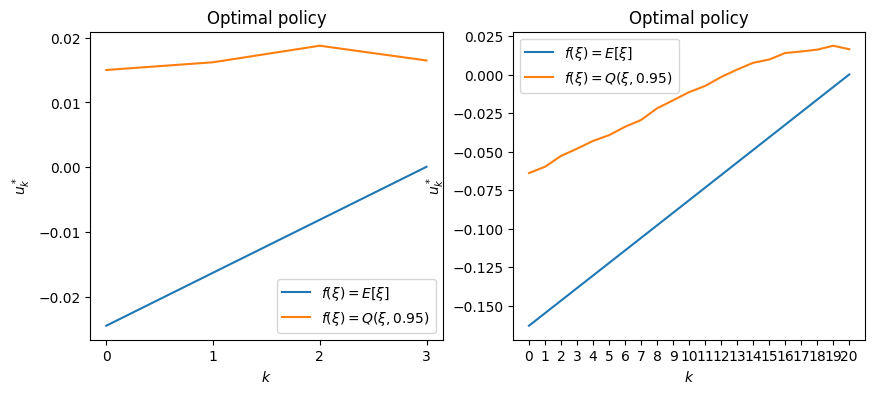

In [6]:
def analytical_policy(N: int, 
                      lamb: float = lam, 
                      r: float = R, 
                      tfunc: callable = np.mean, 
                      df: pd.DataFrame = data, 
                      **kwargs):
    """Compute the optimal policy using the analytical approach"""
    k = np.arange(N + 1)
    J_N_k = np.array([
        tfunc(look_forward_ratios(df, n))
        for n in np.arange(N, -1, -1)
    ])
    return J_N_k - (N - k) * (np.log(1 + r) + 1 / lamb)

def compare_policies(n: int, 
                     ax = None, 
                     pol_generator: callable = analytical_policy, 
                     verbose: bool = True, 
                     **kwargs):
    """Generates policies with the two different terminal functions
        and optionally prints and/or plots them."""
    pol_E = pol_generator(N=n, **kwargs)
    pol_Q = pol_generator(N=n, tfunc=q95, **kwargs)
    if verbose:
        msg = "\nOptimal policy with N={} and {} as terminal cost:\n{}"
        print(msg.format(n, "E[xi]", pol_E))
        print(msg.format(n, "Q(xi, 0.95)", pol_Q))
    if ax is not None:
        ax.plot(pol_E, label="$f(\\xi)=E[\\xi]$")
        ax.plot(pol_Q, label="$f(\\xi)=Q(\\xi, 0.95)$")
        ax.set_xticks(np.arange(n + 1))
        ax.set_xlabel("$k$")
        ax.set_ylabel("$u_k^*$")
        ax.set_title("Optimal policy")
        ax.legend()

axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
compare_policies(n=3, ax=axes[0])
compare_policies(n=20, ax=axes[1])
plt.show()

### A few observations

1. As we get closer to the deadline, our bids increase. This makes sense considering that we have fewer days left to buy the asset if our bid fails.  
2. The terminal-value function makes a large difference: if we use the high-quantile-based function, our bids will always be higher than with the expectation-based function, since the cost of failure is higher.
3. However, even with the more conservative quantile-based terminal-value function, if we have enough time ahead of us we can optimally bid at significant discounts.  

## 3. Validation with back-chain algorithm

To apply the back-chain algorithm, we first need to bound and discretize the action space. The original domain of $u_k$ is on $(-\infty, +\infty)$; we will bound it on $[\inf\xi^{(N-k)}, \sup\xi^{(N-k)}]$ and split it into an arbitrary number of equal-size bands.  

We will exploit the fact that the action taken at step $k$ does not impact the action space of step $k+1$ apart from defining whether we still need to bid or not.  

Since the back-chain algorithm was the focus of a previous assignment, we will not reiterate the explanations of how its works.

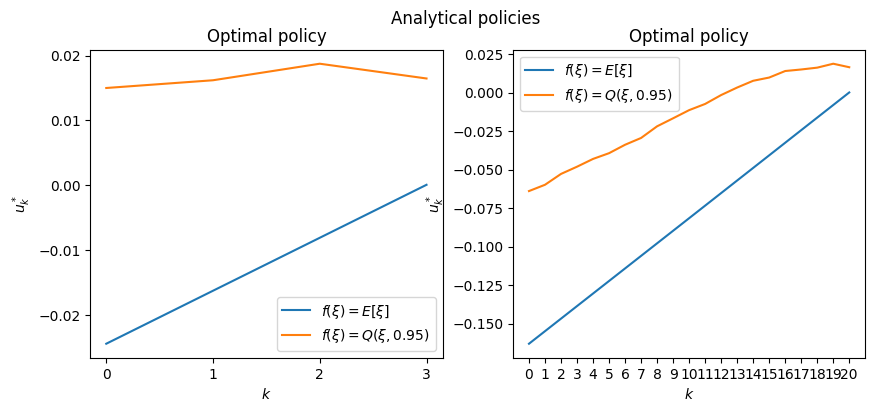

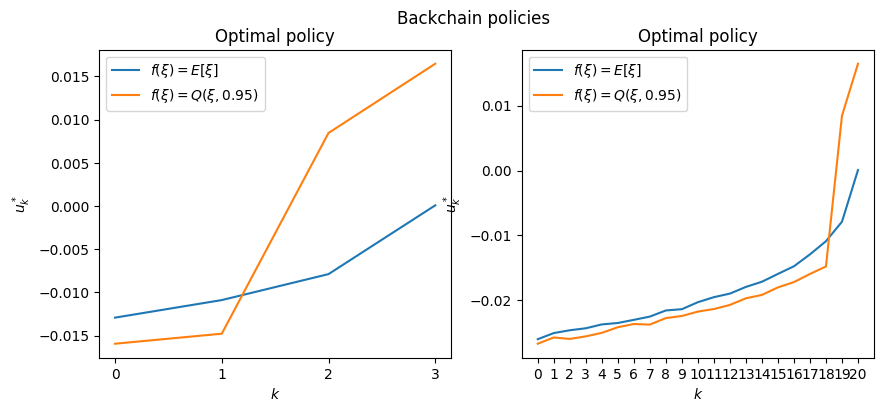

In [7]:
# Define the cost estimation functions separately; this will leave us with
# more flexibility once we get to section 4
def P_u(x: np.ndarray,
        lamb: float = lam,
        **kwargs):
    """Pr(w <= x)"""
    return np.exp(lamb * x)

def J_estimator(action_range: np.ndarray,
                F_u: callable = P_u,
                r: float = R,
                E_J_ns: float = None,
                **kwargs):
    """Outputs a vector of expected costs for a given range of 
    discretized possible actions"""
    p_u = F_u(x=action_range, **kwargs)
    return p_u * action_range + (1 - p_u) * (E_J_ns - np.log(1 + r))

def backchain_step(k: int, 
                   N: int, 
                   J_estimator: callable = J_estimator, 
                   tfunc: callable = np.mean, 
                   df: pd.DataFrame = data, 
                   m: int = 100, 
                   **kwargs):
    """Computes the optimal policy and expected cost for 
    a single back-chain algorithm step."""
    xi = look_forward_ratios(df, N-k)
    u_N = tfunc(xi)
    if k == N:
        return u_N, u_N
    else:
        u_range = np.linspace(xi.min(), xi.max(), m)
        #u_range = np.linspace(xi.min(), 0, m)
        poss_J = J_estimator(u_range, **kwargs)
        best = np.argmin(poss_J)
        return u_range[best], poss_J[best]

def backchain_algo(N: int,
                   **kwargs):
    """Applies the back-chain algorithm with horizon N."""
    results = np.zeros((N+1, 2))
    for j in range(N, -1, -1):
        u_k, J_k = backchain_step(N-j, N-j, **kwargs)
        for k in range(N, j-1, -1):
            u_k, J_k = backchain_step(k, N, E_J_ns=J_k, **kwargs)
        results[j] = u_k, J_k
    return (
        pd
        .DataFrame(
            results,
            columns = ["Bid", "Value"])
        .rename_axis("k", axis=0)
        )


args = {"m": 1000, "verbose": False}
# We output the analytical-policy plots again for easier comparison
axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
compare_policies(n=3, ax=axes[0], **args)
compare_policies(n=20, ax=axes[1], **args)
plt.suptitle("Analytical policies")
plt.show()

backchain_policy = lambda *a, **ka: backchain_algo(*a, **ka).Bid.to_numpy()
args["pol_generator"] = backchain_policy
axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
compare_policies(n=3, ax=axes[0], **args)
compare_policies(n=20, ax=axes[1], **args)
plt.suptitle("Backchain policies")
plt.show()

The results are quite different! One would have expected them to be quite similar - it seems likely that I made a mistake somewhere.  

Assuming the results are correct, however, it's interesting to see how a costlier terminal function appears to push the backchain policies towards lower bids in early steps than with a lower-cost terminal function, while increasing sharply a few steps before the deadline.

### Are the policies optimal?

#### First test: Bellman optimality

Let $\pi^*\equiv(u_0^*, ..., u_{N-1}^*)$ be our optimal step-wise policy. According to Bellman's optimality principle in the stochastic case, a truncated policy $\pi_j^*\equiv(u_j^*, ..., u_{N-1}^*)$ with $j\le N-1$ should be equal to $\pi^*$ where their indices match. Let's apply this test to both approaches:

In [8]:
def bellman_test(pol_generator: callable,
                 lengths: list = [3, 10],
                 **kwargs):
    """For a given policy generator, checks that truncated policies
    equal policies of the truncated length."""
    policies = [
        pol_generator(N=n, **kwargs)[-min(lengths):]
        for n in np.sort(lengths)
    ]
    print("Passed" if np.equal(*policies).all() else "Failed")

bellman_test(pol_generator=analytical_policy)
bellman_test(pol_generator=analytical_policy, tfunc=q95)
bellman_test(pol_generator=backchain_policy)
bellman_test(pol_generator=backchain_policy, tfunc=q95)

Passed
Passed
Passed
Passed


#### Second test: Simulation with noise

We will now test the optimality of our policies using simulations of our presumed distributions. For each test, we start by generating a $(m\times (N+1))$ matrix whose first $N$ columns are independent random variates of $\omega_k$ (we will denote this matrix by $\Omega$); the last column is a fixed terminal value. Each row will represent a simulated episode where we apply the policy, and will be indexed by $i\in\{1,...,m\}$.  

Then, we compute our optimal policy using the whichever policy generator we are currently testing. We will call this $N$-vector $\pi^*$. From this, we derive "noisy policies" for each simulation, noted $\tilde\pi_i^*$:
$$
\begin{aligned}
&\tilde\pi_i^* = \pi^* + I_i\phi_i \\
\text{with}\quad
& \mathbb{P}(I_{i,j}=0)=1-\mathbb{P}(I_{i,j}=1) 
\quad\text{for}\ j={1,...,N}
\\
\text{and}\quad
& \phi_i\sim Normal_N(0, \epsilon) \ ,\ \epsilon > 0
\end{aligned}
$$
(where $\epsilon$ is some small value)  

Then, for each row, we find the first position where $\Omega_i\le\tilde\pi_i^*$ and compute the discounted cost for this simulation using the $g_k$ function described earlier. We repeat this exercice with the non-noisy policy to provide a baseline.  

In the end, we compare the mean simulated costs of noisy versus non-noisy policies, and plot the noisy results against $||I_i\phi_i||_2$, the L2 norms of the $I_i\phi_i$ noise vectors. If our policies are (locally) optimal, we expect to obtain:  
- a higher mean cost for noisy policies compared to non-noisy policies
- a positive correlation between simulated costs and $||I_i\phi_i||_2$

In [9]:
def simulation_test(pol_generator: callable, 
                    w_tilde_generator = intraday_low_generator,
                    validation_mode: bool = False,
                    epsilon: float = .01,
                    r: float = R,
                    N: int = 3,
                    m: int = 8,
                    tfunc: callable = np.mean,
                    df: pd.DataFrame = data,
                    **kwargs):
    """Generates the appropriate policies and random paths following
    the specified parameters, returning vectors containing:
    - simulated costs using optimal (non-noisy) policy
    - simulated costs using presumed suboptimal (noisy) policy
    - simulation-wise noise-vector L2 norms
    """
    W = np.concatenate([
        -w_tilde_generator.rvs(size=(m, N)),
        np.ones((m, 1)) * tfunc(look_forward_ratios(df, N))
        ], axis=1)
    base_policy = pol_generator(N=N, tfunc=tfunc, r=r, df=df, **kwargs)
    base_policy = np.array([base_policy for i in range(m)])
    noise = np.random.normal(scale=epsilon, size=(m, N))
    noise *= np.random.choice([0,1], size=(m, N), p=[.7,.3]) # Make it sparser
    nnorm = np.linalg.norm(noise, ord=2, axis=1)
    noisy_policy = base_policy + np.concatenate([noise, np.zeros((m,1))], axis=1)
    if validation_mode:
        r_ = lambda x: np.round(x, 4)
        print(f"Base policy: {r_(base_policy[0])}")
        print(f"\nScale of noise:\n{r_(nnorm)}")
        print(f"\nNoisy policy:\n{r_(noisy_policy)}")
        print(f"\nSimulated omega and terminal values:\n{r_(W)}")

    def sim_cost(pol):
        X = 1 * (np.cumsum(pol >= W, axis=1) == 0)  # State
        k = np.argmin(X, axis=1)                    # Execution index
        G = pol[range(m), k] - k * np.log(1 + r)    # Discounted costs
        if validation_mode:
            print(f"\nState:\n{X}")
            print(f"\nExecution at: {k}")
            print(f"\nDiscounted cost:\n{r_(G)}")
            print(f"\nMean cost: {G.mean()}")
        return G
    
    base_costs = sim_cost(base_policy)
    noisy_costs = sim_cost(noisy_policy)
    return base_costs, noisy_costs, nnorm

print("A small test to check that everything works...\n")
base_costs, noisy_costs, noise = simulation_test(
    pol_generator = analytical_policy, 
    validation_mode = True
)
base_costs.mean(), noisy_costs.mean(), noise.mean()

A small test to check that everything works...

Base policy: [-0.0244 -0.0162 -0.0081  0.0001]

Scale of noise:
[0.0074 0.0095 0.     0.0044 0.     0.0034 0.     0.    ]

Noisy policy:
[[-0.0244 -0.0162 -0.0155  0.0001]
 [-0.0149 -0.0162 -0.0081  0.0001]
 [-0.0244 -0.0162 -0.0081  0.0001]
 [-0.0244 -0.0119 -0.0081  0.0001]
 [-0.0244 -0.0162 -0.0081  0.0001]
 [-0.0275 -0.0147 -0.0081  0.0001]
 [-0.0244 -0.0162 -0.0081  0.0001]
 [-0.0244 -0.0162 -0.0081  0.0001]]

Simulated omega and terminal values:
[[-0.009  -0.0162 -0.0205 -0.0005]
 [-0.0038 -0.0013 -0.001  -0.0005]
 [-0.0092 -0.0075 -0.0154 -0.0005]
 [-0.0212 -0.0022 -0.0054 -0.0005]
 [-0.0082 -0.0006 -0.0044 -0.0005]
 [-0.0053 -0.0008 -0.0165 -0.0005]
 [-0.0062 -0.0087 -0.0032 -0.0005]
 [-0.0134 -0.0012 -0.0103 -0.0005]]

State:
[[1 1 0 0]
 [1 1 1 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 0 0]]

Execution at: [2 3 2 3 3 2 3 2]

Discounted cost:
[-0.0082 -0.0002 -0.0082 -0.0002 -0.0002 -0.0082 -0.0002 -0.0082]



(-0.0042017734024492924, -0.005123465751098826, 0.0030860721771653753)


Results for analytical policy:
  Cost mean:	-0.006999676812416473
  Noise penalty: 0.000761875444427141
  Penalty-noise correlation: 0.1402087396851965

Results for backchain policy:
  Cost mean:	-0.01311714923109929
  Noise penalty: 0.002298599031739402
  Penalty-noise correlation: 0.34444459541917183


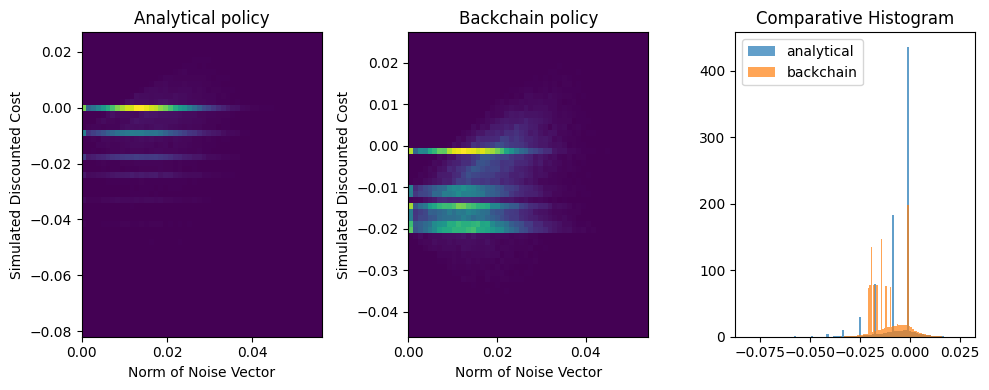

In [10]:
def compare_optimalities(pol_generators: callable,
                         N: int = 10,
                         m: int = 100_000,
                         **kwargs):
    """Visually compares the performances and approximate optimalities
    of competing policy generators"""
    nbins = max(10, min(100, m // 50))
    axes = plt.subplots(ncols=len(pol_generators) + 1, figsize=(10, 4))[1]
    for i, (label, pol_gen) in enumerate(pol_generators.items()):
        base_costs, cost, noise = simulation_test(
            pol_generator=pol_gen, N=N, m=m, **kwargs)
        print(f"\nResults for {label} policy:\n  Cost mean:\t{base_costs.mean()}")
        penalty = cost - base_costs
        print(f"  Noise penalty: {penalty.mean()}")
        print(f"  Penalty-noise correlation: {np.corrcoef(penalty, noise)[0,1]}")
        axes[i].hist2d(noise, cost, bins=(nbins // 2, nbins // 2))
        axes[i].set_title(f"{label.title()} policy")
        axes[i].set_xlabel("Norm of Noise Vector")
        axes[i].set_ylabel("Simulated Discounted Cost")
        axes[-1].hist(cost, label=label, density=True, alpha=.7, bins=nbins)
    axes[-1].legend()
    axes[-1].set_title("Comparative Histogram")
    plt.tight_layout()
    plt.show()

pol_generators = {
    "analytical": analytical_policy,
    "backchain": backchain_policy
}
compare_optimalities(pol_generators=pol_generators)


Results for analytical policy:
  Cost mean:	-0.005355557029343365
  Noise penalty: 0.0017354394617568626
  Penalty-noise correlation: 0.26308339260392744

Results for backchain policy:
  Cost mean:	-0.009032446447024743
  Noise penalty: 0.0008389322455985764
  Penalty-noise correlation: 0.12780895107674184


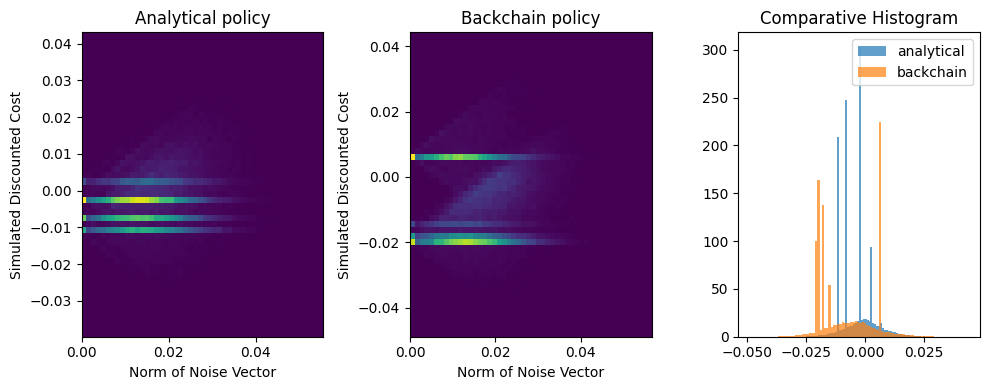

In [11]:
compare_optimalities(pol_generators=pol_generators, tfunc=q95)

#### Discussion of results

The simulation results suggest I made a mistake in my analytical derivation of the optimal policies, since the backchain-based policies appear to perform slightly better. However, both approaches:  
- respect Bellman's optimality principle
- appear to represent (local) optima, since there is a positive correlation between the L2 norm of the noise vectors and the cost penalty produced by deviating from our computed policies

## 4. Trying with different models/examples

### Changing the underlying probability distribution

Let $\omega'_k$ be $\omega_k$ with the zero-valued observations removed. We replace our underlying distribution with a Gamma distribution fitted on $\omega'_k$.

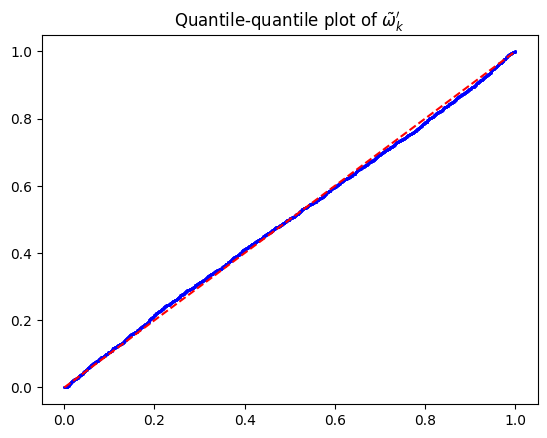

In [12]:
w_prime = intraday_low[intraday_low != 0]
mod_intraday_low_generator = gamma(*gamma.fit(-w_prime))
x = np.sort(-w_prime)
u = np.linspace(0,1,len(x))
plt.plot(u, u, color="r", linestyle="dashed")
plt.scatter(u, mod_intraday_low_generator.cdf(x), s=1, color="b")
plt.title("Quantile-quantile plot of $\\tilde\omega_k'$")
plt.show()

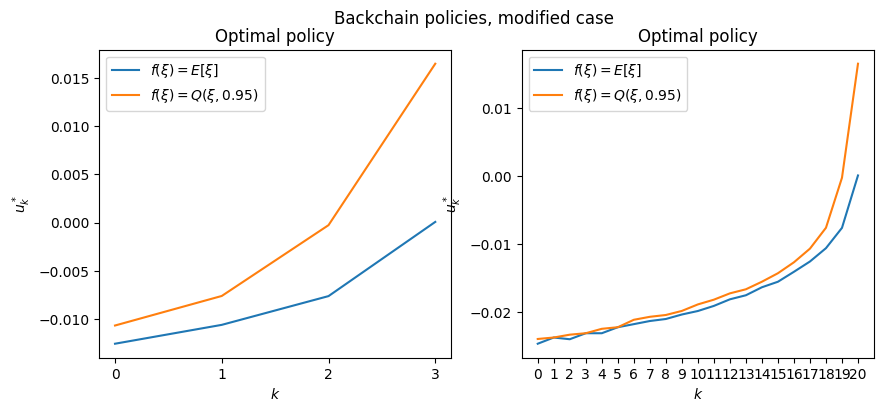


Results for analytical policy:
  Cost mean:	-0.006747388053499353
  Noise penalty: 0.0008007720740849634
  Penalty-noise correlation: 0.1506831998386208

Results for backchain policy:
  Cost mean:	-0.012963858453396534
  Noise penalty: 0.0024876945891121067
  Penalty-noise correlation: 0.3649454315865762


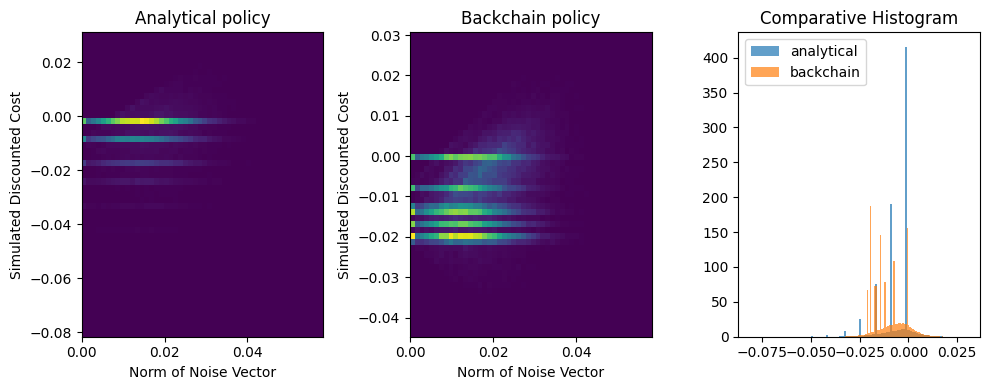

In [13]:
P_u_alt = lambda x, **ka: 1 - mod_intraday_low_generator.cdf(-x)
args = { # To avoid repetition
    "pol_generator": backchain_policy,
    "m": 1000,
    "verbose": False,
    "F_u": P_u_alt
}
axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
compare_policies(n=3, ax=axes[0], **args)
compare_policies(n=20, ax=axes[1], **args)
plt.suptitle("Backchain policies, modified case")
plt.show()

compare_optimalities(
    pol_generators = pol_generators,
    w_tilde_generator = mod_intraday_low_generator,
    F_u = P_u_alt
)

### Changing the daily interest rate

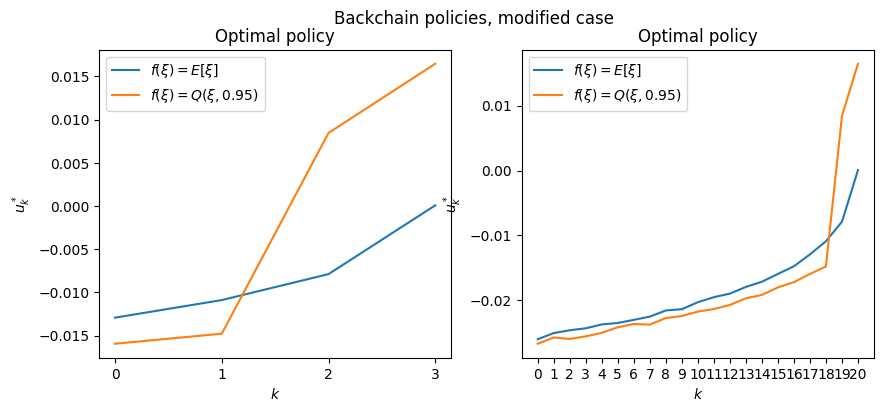


Results for analytical policy:
  Cost mean:	-0.009038329180130754
  Noise penalty: 0.000717755933082253
  Penalty-noise correlation: 0.13617612213290156

Results for backchain policy:
  Cost mean:	-0.014458487270427381
  Noise penalty: 0.0025111148712962743
  Penalty-noise correlation: 0.37362160366038705


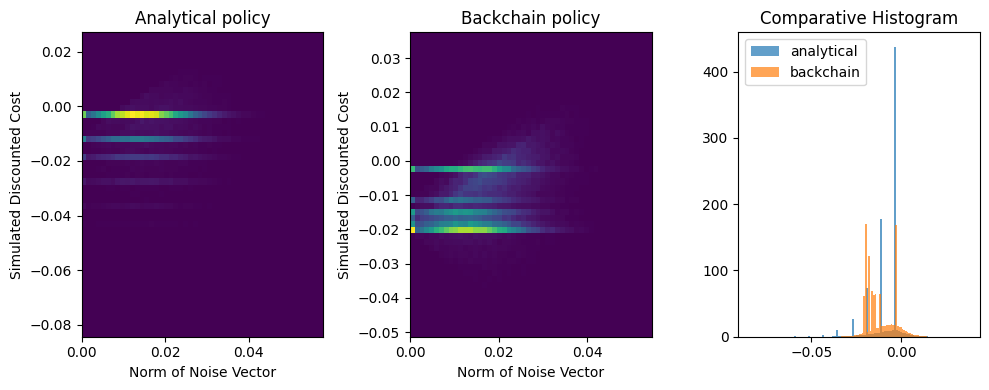

In [14]:
axes = plt.subplots(ncols=2, figsize=(10, 4))[1]
del args["F_u"]
compare_policies(n=3, ax=axes[0], **args)
compare_policies(n=20, ax=axes[1], **args)
plt.suptitle("Backchain policies, modified case")
plt.show()

compare_optimalities(pol_generators=pol_generators, r=R*4)

## Sources

- I reused some of my Markdown from assignment #2 (for step functions in particular)  
- The Bellman optimality concept was taken course slides; so was the basic idea of the stopping-time problem, especially from a buyer’s side, which got me started on the math  
- The code snippet where I download historical stock price data was built reusing some code from a personal (unpublished) project of mine, itself with nontrivial help from the yfinance package documentation: https://pypi.org/project/yfinance/